In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import month, year

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pyspark.sql.functions import substring
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import length
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from builtins import round
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import percent_rank
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date
import urllib.request
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns; sns.set_theme()
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import itertools
from scipy import stats

from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("UK Firearm Analysis") \
    .getOrCreate()

In [3]:
# Checking the spark session
spark

In [4]:
#Increasing the broadcastTimeout for slow VMs
spark.conf.set("spark.sql.broadcastTimeout", "700")  # sets the timeout to 700 seconds

In [5]:
# Download the file from the blob storage to a local environment
file_url = "https://bigdatafinal.blob.core.windows.net/crimedata/LSOA_pop_v2.csv"
local_filename = "LSOA_pop_v2.csv"
urllib.request.urlretrieve(file_url, local_filename)

# Read the local file into PySpark DataFrame
lsoa_pop_df = spark.read.csv(local_filename, header=True, inferSchema=True)
lsoa_pop_df.show(2)

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+------------

In [6]:
lsoa_pop_df.count() #Checking the number of rows

34753

In [7]:
# Download the file from the blob storage to a local environment
file_url = "https://bigdatafinal.blob.core.windows.net/crimedata/all_crimes21.hdr.txt.gz"
local_filename = "all_crimes21_hdr.txt.gz"
urllib.request.urlretrieve(file_url, local_filename)

# Read the local file into PySpark DataFrame
crime_data_df_full = spark.read.csv(local_filename, header=True, inferSchema=True)
crime_data_df_full.show(2)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
+--------+-------+--------------------+--------------------+---------+---------+

In [8]:
crime_data_df_full.count() #Checking the number of rows

65078250

In [9]:
#Check that the files are there
!ls -l *.csv *.txt.gz

-rw-r--r-- 1 notebookuser notebookuser    2505684 Sep 23 02:33 LSOA_pop_v2.csv
-rw-r--r-- 1 notebookuser notebookuser 2491979339 Sep 23 02:33 all_crimes21_hdr.txt.gz


In [10]:
#Filtering crime dataframe to only have data up until 2018, following the claims that need to be verified
crime_data_df = crime_data_df_full.filter(year(crime_data_df_full['Month']) <= 2018)
#Checking that the previous line worked and we only have years from 2010 to 2018
distinct_years = crime_data_df.select(year(crime_data_df["Month"]).alias("Year")).distinct().orderBy("Year")

distinct_years.show()

+----+
|Year|
+----+
|2010|
|2011|
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
+----+



In [11]:
#Confirming the InferSchema
crime_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [12]:
#Confirming the InferSchema
lsoa_pop_df.printSchema()

root
 |-- date: integer (nullable = true)
 |-- geography: string (nullable = true)
 |-- geography code: string (nullable = true)
 |-- Rural Urban: string (nullable = true)
 |-- Variable: All usual residents; measures: Value: integer (nullable = true)
 |-- Variable: Males; measures: Value: integer (nullable = true)
 |-- Variable: Females; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a household; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a communal establishment; measures: Value: integer (nullable = true)
 |-- Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value: integer (nullable = true)
 |-- Variable: Area (Hectares); measures: Value: double (nullable = true)
 |-- Variable: Density (number of persons per hectare); measures: Value: double (nullable = true)



In [13]:
#Checking for null, None, or NaN Values in sample_data df
crime_data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in crime_data_df.columns]).show()
#As we can see, the sample dataset has several thousand missing values in the following columns: 
#Crime ID, Longitude, Latitude, LSOA code, LSOA name, Last outcome category and Context

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|20358801|    0|          0|           0|   652049|  652049|       0|  1833664|  1833664|         0|             22301098|49636344|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



In [14]:
#Checking for null, None, or NaN Values in lasoa_pop df
lsoa_pop_df.select([count(when(col(c).isNull(), c)).alias(c) for c in lsoa_pop_df.columns]).show()
#As we can see, there are no missing values

+----+---------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+---------+--------------

In [15]:
# Checking for duplicate rows on the lsoa dataset
lsoa_pop_duplicates = lsoa_pop_df.groupBy(lsoa_pop_df.columns).count().filter(col("count")>1)
lsoa_pop_duplicates.show() #No dupicate rows present

+----+---------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+-----+
|date|geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|count|
+----+---------+--

In [16]:
#Checking to see the distinct types of crime in the Crime Type column.
#We can and should include Violence and sexual offences among the violent crimes required by the question
crime_data_df.select("Crime type").distinct().show(truncate = False)

+----------------------------+
|Crime type                  |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
|Anti-social behaviour       |
+----------------------------+



In [17]:
#Checking to see if the term "vioent crimes" was always used, or was replaced by some other terminology
# Extract year from the 'Month' column
crime_data_df = crime_data_df.withColumn("Year", year("Month"))

# Select distinct 'CrimeType' and 'Year' and order by 'Year'
ordered_data = crime_data_df.select("Crime type", "Year").distinct().orderBy("Year")
pd.set_option('display.max_rows', None)
#Convert to Pandas for clearer display
ordered_data_pd = ordered_data.toPandas()
ordered_data_pd.head(50)
#"Violent Crime" changed from 2014 on to "Violence and sexual offences"

,Crime type,Year
0,Burglary,2010
1,Other crime,2010
2,Vehicle crime,2010
3,Violent crime,2010
4,Robbery,2010
5,Anti-social behaviour,2010
6,Anti-social behaviour,2011
7,Other theft,2011
8,Drugs,2011
9,Shoplifting,2011


In [18]:
#Creating a df with dates and crime types
crime_timeframe = crime_data_df.select("Month", "Crime type")
crime_timeframe.show(5)

+-------+--------------------+
|  Month|          Crime type|
+-------+--------------------+
|2010-12|         Other crime|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
+-------+--------------------+
only showing top 5 rows



In [19]:
#Filtering all the crime types by keyword so as to isolate 'Violent' and 'Violence'
violent_crimes = \
crime_timeframe.filter((F.col("Crime type").contains('Violent')) | (F.col("Crime type").contains('Violence')))
violent_crimes.show(5)

+-------+-------------+
|  Month|   Crime type|
+-------+-------------+
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
+-------+-------------+
only showing top 5 rows



In [20]:
# Format the 'Month' column to 'yyyy-MM-dd' 
violent_crimes_2 = violent_crimes.withColumn("Month", date_format("Month", "yyyy-MM-dd"))

violent_crimes_2.show(5)

+----------+-------------+
|     Month|   Crime type|
+----------+-------------+
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 5 rows



In [21]:
# Group by Year and then count the amount of violent crimes per year so as to be able to create a time series analysys
violent_crimes_yearly_2 = (violent_crimes_2
                         .groupBy(("Month"))
                         .count().withColumnRenamed("count", "Violent Crimes")
                         .orderBy("Month"))

violent_crimes_yearly_2.show(10)

+----------+--------------+
|     Month|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
+----------+--------------+
only showing top 10 rows



In [22]:
#Changing the Month column from string type to date type
violent_crimes_yearly_3 = \
violent_crimes_yearly_2.select(to_date(col('Month'), "yyyy-MM-dd").alias('date'), 'Violent Crimes')
violent_crimes_yearly_3.show(5)

+----------+--------------+
|      date|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
+----------+--------------+
only showing top 5 rows



In [23]:
#Checking schema
violent_crimes_yearly_3.printSchema()

root
 |-- date: date (nullable = true)
 |-- Violent Crimes: long (nullable = false)



In [24]:
#Converting to pandas
violent_crimes_pandas = violent_crimes_yearly_3.toPandas()
violent_crimes_pandas.head(5)

,date,Violent Crimes
0,2010-12-01,57580
1,2011-01-01,59823
2,2011-02-01,56691
3,2011-03-01,62326
4,2011-04-01,64299


In [25]:
#Convert the "date" column of the violent_crimes_pd dataframe into a datetime format
#Set the "date" column as the index of the dataframe
violent_crimes_pandas.date = violent_crimes_pandas.date.astype('datetime64[ns]')
violent_crimes_pandas2 = violent_crimes_pandas.set_index(pd.to_datetime(violent_crimes_pandas.date))
violent_crimes_pandas2.head(5)

,date,Violent Crimes
date,,
2010-12-01,2010-12-01,57580
2011-01-01,2011-01-01,59823
2011-02-01,2011-02-01,56691
2011-03-01,2011-03-01,62326
2011-04-01,2011-04-01,64299


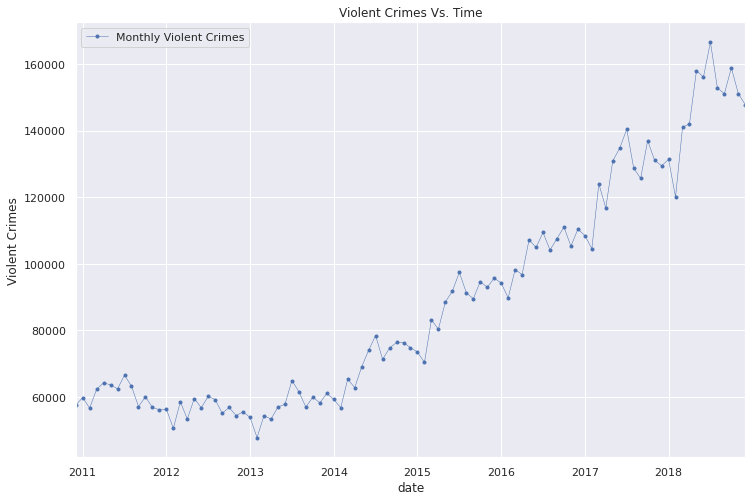

In [26]:
#Time series Plot showing year vs. number of violent crimes
#Plotting complete time series up until 2018
violent_crimes_pandas2.plot(y='Violent Crimes', x='date',marker='.', linestyle='-', linewidth=0.5,\
subplots=False,
label='Monthly Violent Crimes', figsize=(12,8),
title='Violent Crimes Vs. Time')
plt.ylabel('Violent Crimes')
plt.show()
#The trend shows a yearly increase in vilent crimes.
#However a commulative plot will shed some light

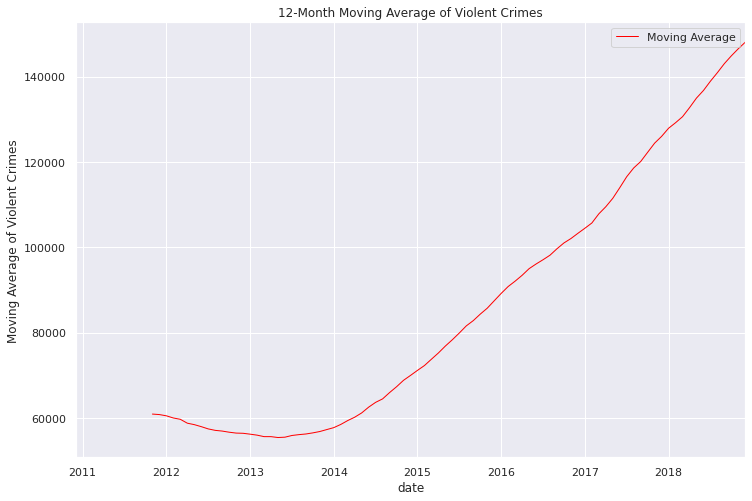

In [27]:
# Computing and plotting the moving average using a 12 month window
violent_crimes_pandas2['Moving Average'] = violent_crimes_pandas2['Violent Crimes'].rolling(window=12).mean()
violent_crimes_pandas2.plot(y='Moving Average', 
                            x='date', 
                            linestyle='-', 
                            color='red', 
                            linewidth=1, 
                            figsize=(12,8), 
                            title='12-Month Moving Average of Violent Crimes')

plt.ylabel('Moving Average of Violent Crimes')
plt.show()

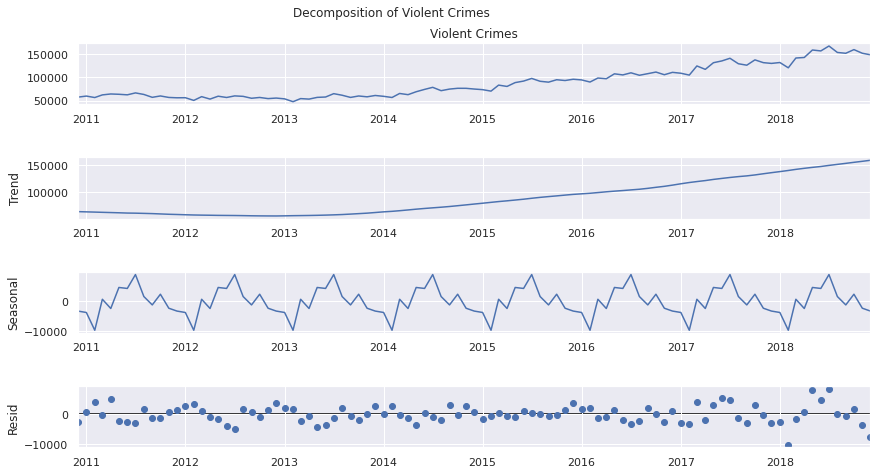

In [28]:
#Decomposing the plot into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(violent_crimes_pandas2['Violent Crimes'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
fig.suptitle('Decomposition of Violent Crimes')
plt.show()

In [29]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    # Determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    # Plotting the statistics
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label=title)
    ax.plot(rolmean, label='Rolling Mean')
    ax.plot(rolstd, label='Rolling Std')
    ax.legend()
    ax.set_title('Rolling Mean & Standard Deviation')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Violent Crimes')
    plt.tight_layout()
    plt.show()

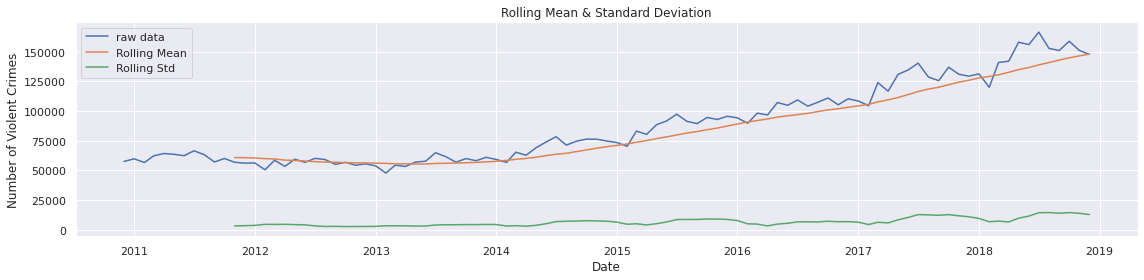

In [30]:
#Testing stationarity
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(violent_crimes_pandas2['Violent Crimes'],'raw data')

In [31]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
  print(' > Is the {} stationary ?'.format(dataDesc))
  dftest = adfuller(timeseries.dropna(), autolag='AIC')
  print('Test statistic = {:.3f}'.format(dftest[0]))
  print('P-value = {:.3f}'.format(dftest[1]))
  print('Critical values :')
  for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [32]:
#Applying test to the Violent Crimes column
ADF_test(violent_crimes_pandas2['Violent Crimes'],'raw data')

 > Is the raw data stationary ?
Test statistic = 1.087
P-value = 0.995
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is not stationary with 95% confidence
	10%: -2.5854823866213152 - The data is not stationary with 90% confidence


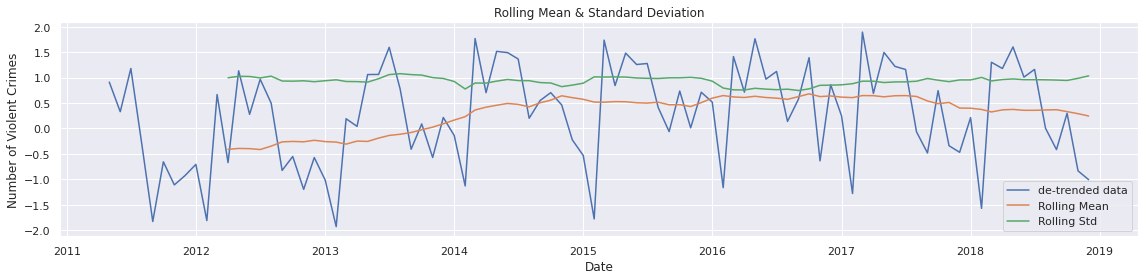

 > Is the de-trended data stationary ?
Test statistic = -2.112
P-value = 0.240
Critical values :
	1%: -3.5159766913976376 - The data is not stationary with 99% confidence
	5%: -2.898885703483903 - The data is not stationary with 95% confidence
	10%: -2.5866935058484217 - The data is not stationary with 90% confidence


In [33]:
# Detrending
y = violent_crimes_pandas2['Violent Crimes']
y_detrend =  (y - y.rolling(window=6).mean()) / y.rolling(window=6).std()
#Testing stationarity again
test_stationarity(y_detrend, 'de-trended data')
ADF_test(y_detrend, 'de-trended data')

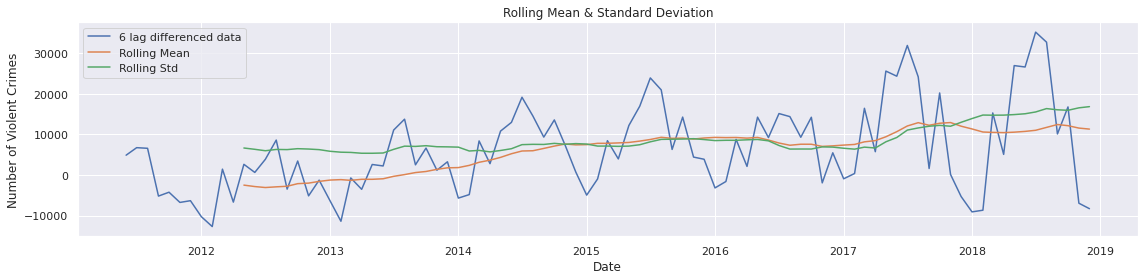

 > Is the 6 lag differenced data stationary ?
Test statistic = -1.299
P-value = 0.630
Critical values :
	1%: -3.5137900174243235 - The data is not stationary with 99% confidence
	5%: -2.8979433868293945 - The data is not stationary with 95% confidence
	10%: -2.5861907285474777 - The data is not stationary with 90% confidence


In [34]:
# Differencing
y_6lag =  y - y.shift(6)
#Testing stationarity again
test_stationarity(y_6lag,'6 lag differenced data')
ADF_test(y_6lag,'6 lag differenced data')

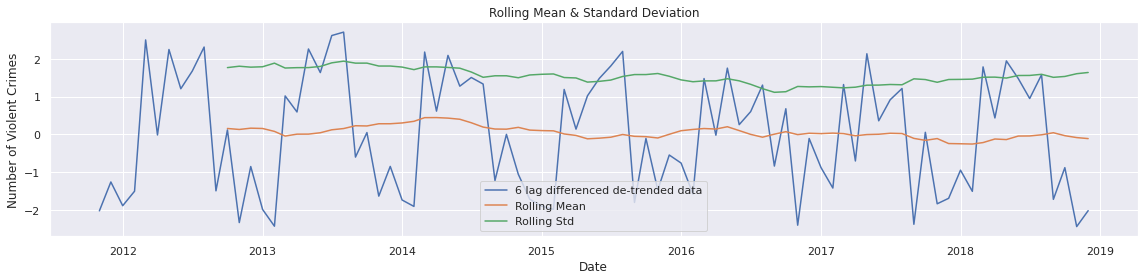

 > Is the 6 lag differenced de-trended data stationary ?
Test statistic = -5.795
P-value = 0.000
Critical values :
	1%: -3.5159766913976376 - The data is  stationary with 99% confidence
	5%: -2.898885703483903 - The data is  stationary with 95% confidence
	10%: -2.5866935058484217 - The data is  stationary with 90% confidence


In [35]:
# Detrending + Differencing
y_6lag_detrend =  y_detrend - y_detrend.shift(6)
#Testing stationarity again
test_stationarity(y_6lag_detrend,'6 lag differenced de-trended data')
ADF_test(y_6lag_detrend,'6 lag differenced de-trended data')

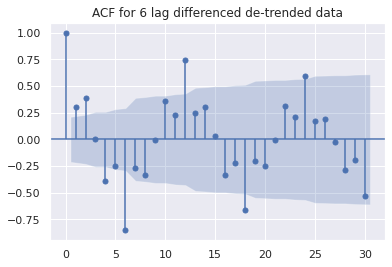

In [36]:
# Plot ACF
plot_acf(y_6lag_detrend.dropna(), lags=30)
plt.title("ACF for 6 lag differenced de-trended data")
plt.show()

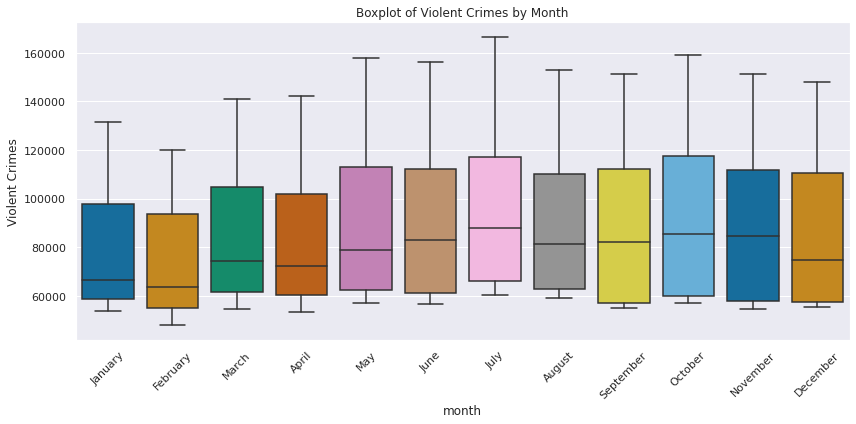

In [37]:
# Generating a boxplot
violent_crimes_pandas['date'] = pd.to_datetime(violent_crimes_pandas['date']) #converting to datetime
violent_crimes_pandas['month'] = violent_crimes_pandas['date'].dt.month_name() #Extracting the month name to be used later

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Violent Crimes', data=violent_crimes_pandas, 
order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
           palette='colorblind')  # Using colorblind palette)
plt.title("Boxplot of Violent Crimes by Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
percentage_change = violent_crimes_pandas2.resample('Y').sum() #This line aggregates the data by year (Y)
percentage_change.head(5)

,Violent Crimes,Moving Average
date,,
2010-12-31,57580,0.00000000
2011-12-31,729387,121682.58333333
2012-12-31,676732,696199.83333333
2013-12-31,687233,673017.66666667
2014-12-31,839521,759553.91666667


In [39]:
#Yearly percentage change plot
# Calculate the percentage change
percentage_change['Percentage Change'] = percentage_change['Violent Crimes'].pct_change()*100
percentage_change.round(2).head(15)

,Violent Crimes,Moving Average,Percentage Change
date,,,
2010-12-31,57580,0.00000000,NaN
2011-12-31,729387,121682.58000000,1166.74000000
2012-12-31,676732,696199.83000000,-7.22000000
2013-12-31,687233,673017.67000000,1.55000000
2014-12-31,839521,759553.92000000,22.16000000
2015-12-31,1049476,949391.17000000,25.01000000
2016-12-31,1239325,1157785.33000000,18.09000000
2017-12-31,1512080,1380912.92000000,22.01000000
2018-12-31,1777053,1654701.83000000,17.52000000


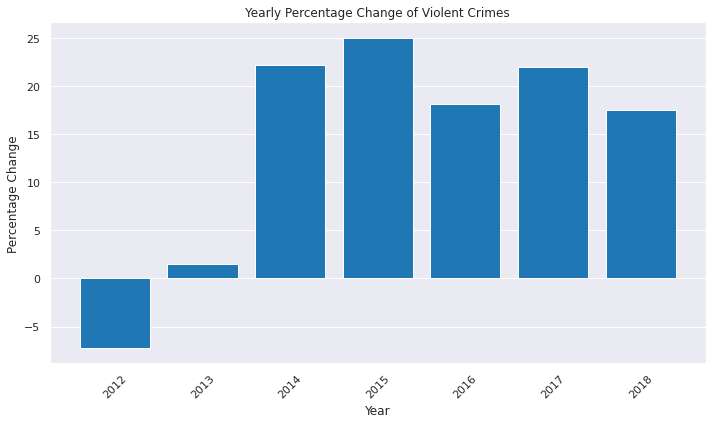

In [40]:
# Convert the date index to string format for plotting
date_as_str = percentage_change.index.strftime('%Y')
# yearly percentage change plot
plt.figure(figsize=(10, 6))
bars = plt.bar(date_as_str[2:], percentage_change['Percentage Change'][2:], color = 'tab:blue')
#Percentage change from 2010 to 2011 has been excluded because the limited 2010 data would have 
#skewed the results, showing 2011 as the biggest percentage change of all
plt.title('Yearly Percentage Change of Violent Crimes')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.grid(axis='x')
plt.xticks(date_as_str[2:], rotation=45)
plt.tight_layout()
plt.show()

In [41]:
#Splitting the violent_crimes_df "Month" column into "Year" and "Month" in order to create a monthly heatmap
violent_crimes_monthly = \
violent_crimes.groupBy(year("Month").alias("Year"), month("Month").alias("Month")).count().orderBy("Year", "Month")
violent_crimes_monthly.show()

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2010|   12|57580|
|2011|    1|59823|
|2011|    2|56691|
|2011|    3|62326|
|2011|    4|64299|
|2011|    5|63633|
|2011|    6|62475|
|2011|    7|66572|
|2011|    8|63284|
|2011|    9|57150|
|2011|   10|60076|
|2011|   11|56895|
|2011|   12|56163|
|2012|    1|56324|
|2012|    2|50598|
|2012|    3|58606|
|2012|    4|53415|
|2012|    5|59541|
|2012|    6|56816|
|2012|    7|60199|
+----+-----+-----+
only showing top 20 rows



In [42]:
#Converting violent_crimes_df to Pandas
violent_crimes_monthly_pandas = violent_crimes_monthly.toPandas()
violent_crimes_monthly_pandas.head(5)

,Year,Month,count
0,2010,12,57580
1,2011,1,59823
2,2011,2,56691
3,2011,3,62326
4,2011,4,64299


In [43]:
# Creating a pivot table with years as columns and months as rows.
heatmap_data_df = violent_crimes_monthly_pandas.pivot(index='Month', columns='Year', values='count')
heatmap_data_df.head(12)

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018
Month,,,,,,,,,
1,NaN,59823.00000000,56324.00000000,53872.00000000,59291.00000000,73515.00000000,94278.00000000,108513.00000000,131372.00000000
2,NaN,56691.00000000,50598.00000000,47842.00000000,56798.00000000,70385.00000000,89779.00000000,104560.00000000,120095.00000000
3,NaN,62326.00000000,58606.00000000,54439.00000000,65372.00000000,83187.00000000,98294.00000000,124052.00000000,140969.00000000
4,NaN,64299.00000000,53415.00000000,53367.00000000,62825.00000000,80384.00000000,96798.00000000,116794.00000000,142118.00000000
5,NaN,63633.00000000,59541.00000000,57031.00000000,69063.00000000,88564.00000000,107262.00000000,130953.00000000,158060.00000000
6,NaN,62475.00000000,56816.00000000,57815.00000000,74066.00000000,91790.00000000,104921.00000000,134756.00000000,156092.00000000
7,NaN,66572.00000000,60199.00000000,64962.00000000,78459.00000000,97441.00000000,109428.00000000,140437.00000000,166579.00000000
8,NaN,63284.00000000,59217.00000000,61607.00000000,71341.00000000,91366.00000000,104174.00000000,128751.00000000,152826.00000000
9,NaN,57150.00000000,55144.00000000,56964.00000000,74723.00000000,89500.00000000,107608.00000000,125670.00000000,151099.00000000


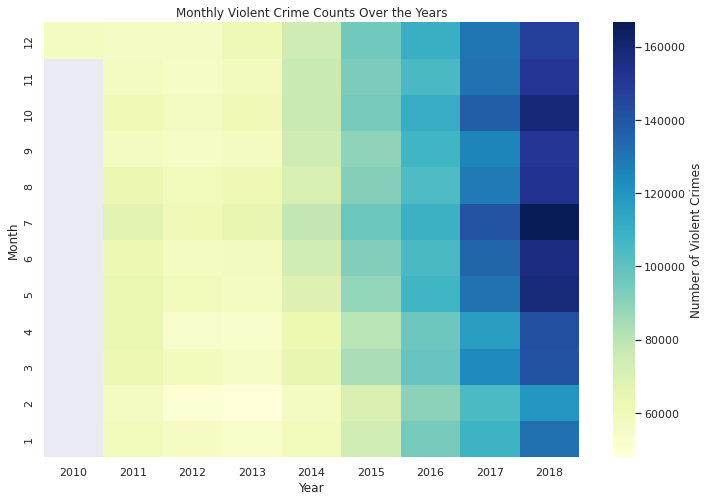

In [44]:
#Creating a heatmap showing the violent crie count over the years
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_df, cmap="YlGnBu", cbar_kws={'label': 'Number of Violent Crimes'})
plt.title("Monthly Violent Crime Counts Over the Years")
plt.gca().invert_yaxis()
plt.show()

## Linear regression models to confirm increase or decrease in violent crimes by looking at the slope

#### Linear regression model data to verify the trend

In [45]:
# Format the 'Month' column to 'yyyy-MM-dd'
violent_crimes_df_2 = violent_crimes.withColumn("Month", date_format("Month", "yyyy-MM-dd"))

violent_crimes_df_2.show(10)

+----------+-------------+
|     Month|   Crime type|
+----------+-------------+
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 10 rows



In [46]:
# Group by Year and then count the amount of violent crimes per year so as to be able to create a time series analysys
violent_crimes_yearly_2 = (violent_crimes_df_2
                         .groupBy(("Month"))
                         .count().withColumnRenamed("count", "Violent Crimes")
                         .orderBy("Month"))

violent_crimes_yearly_2.show(10)

+----------+--------------+
|     Month|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
+----------+--------------+
only showing top 10 rows



In [47]:
# Converting the date to a UNIX timestamp. This will give a continuous numerical 
#representation of the date which is more suitable for linear regression than the date string.
violent_crimes_yearly_2 = \
violent_crimes_yearly_2.withColumn("Date_as_Integer", F.unix_timestamp(violent_crimes_yearly_2['Month'], 'yyyy-MM-dd'))
violent_crimes_yearly_2.show()

+----------+--------------+---------------+
|     Month|Violent Crimes|Date_as_Integer|
+----------+--------------+---------------+
|2010-12-01|         57580|     1291161600|
|2011-01-01|         59823|     1293840000|
|2011-02-01|         56691|     1296518400|
|2011-03-01|         62326|     1298937600|
|2011-04-01|         64299|     1301616000|
|2011-05-01|         63633|     1304208000|
|2011-06-01|         62475|     1306886400|
|2011-07-01|         66572|     1309478400|
|2011-08-01|         63284|     1312156800|
|2011-09-01|         57150|     1314835200|
|2011-10-01|         60076|     1317427200|
|2011-11-01|         56895|     1320105600|
|2011-12-01|         56163|     1322697600|
|2012-01-01|         56324|     1325376000|
|2012-02-01|         50598|     1328054400|
|2012-03-01|         58606|     1330560000|
|2012-04-01|         53415|     1333238400|
|2012-05-01|         59541|     1335830400|
|2012-06-01|         56816|     1338508800|
|2012-07-01|         60199|     

In [48]:
#Normalizing the Date_as_integer column as it is in the billions, which is way too large to run a proper model
# We will normalize the data by subtracting the min value and dividing by the range
# Compute min and range of Date_as_Integer
min_val = violent_crimes_yearly_2.agg({"Date_as_Integer": 'min'}).collect()[0][0]
range_val = (violent_crimes_yearly_2.agg({"Date_as_Integer": 'max'}).collect()[0][0] - min_val)

# Normalize the Date_as_Integer column
violent_crimes_yearly_2 = \
violent_crimes_yearly_2.withColumn("Date_as_Integer_Norm", (col("Date_as_Integer") - min_val) / range_val)
violent_crimes_yearly_2.show(3)

+----------+--------------+---------------+--------------------+
|     Month|Violent Crimes|Date_as_Integer|Date_as_Integer_Norm|
+----------+--------------+---------------+--------------------+
|2010-12-01|         57580|     1291161600|                 0.0|
|2011-01-01|         59823|     1293840000|0.010609171800136893|
|2011-02-01|         56691|     1296518400|0.021218343600273786|
+----------+--------------+---------------+--------------------+
only showing top 3 rows



In [49]:
#Checking out the statistics of the dataframe
violent_crimes_yearly_2.describe("Violent Crimes").show()

+-------+------------------+
|summary|    Violent Crimes|
+-------+------------------+
|  count|                97|
|   mean| 88333.88659793814|
| stddev|33233.102823677014|
|    min|             47842|
|    max|            166579|
+-------+------------------+



In [50]:
#Splitting the data into training set and testing set
#Splitting in chronological order since it is a time series
split_point = int(0.7 * violent_crimes_yearly_2.count())
trainDF = violent_crimes_yearly_2.limit(split_point)
testDF = violent_crimes_yearly_2.subtract(trainDF)

##### Plotting the monthly data in order to perform exploratory data analysis and visualizing the trend before the model

In [51]:
#Change the name of the Month column to 'date'
violent_crimes_yearly_3 = violent_crimes_yearly_2.select(to_date(col('Month'), "yyyy-MM-dd").alias('date'), 'Violent Crimes')
violent_crimes_yearly_3.show()

+----------+--------------+
|      date|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
|2011-10-01|         60076|
|2011-11-01|         56895|
|2011-12-01|         56163|
|2012-01-01|         56324|
|2012-02-01|         50598|
|2012-03-01|         58606|
|2012-04-01|         53415|
|2012-05-01|         59541|
|2012-06-01|         56816|
|2012-07-01|         60199|
+----------+--------------+
only showing top 20 rows



In [52]:
#Converting violent_crimes_yearly_2 to pandas
violent_crimes_pd = violent_crimes_yearly_3.toPandas()
violent_crimes_pd.head()

,date,Violent Crimes
0,2010-12-01,57580
1,2011-01-01,59823
2,2011-02-01,56691
3,2011-03-01,62326
4,2011-04-01,64299


In [53]:
#Convert the Date column data type to datetime64[ns]
violent_crimes_pd.date = violent_crimes_pd.date.astype('datetime64[ns]')
violent_crimes_pd2 = violent_crimes_pd.set_index(pd.to_datetime(violent_crimes_pd.date))
violent_crimes_pd2.head(5)

,date,Violent Crimes
date,,
2010-12-01,2010-12-01,57580
2011-01-01,2011-01-01,59823
2011-02-01,2011-02-01,56691
2011-03-01,2011-03-01,62326
2011-04-01,2011-04-01,64299


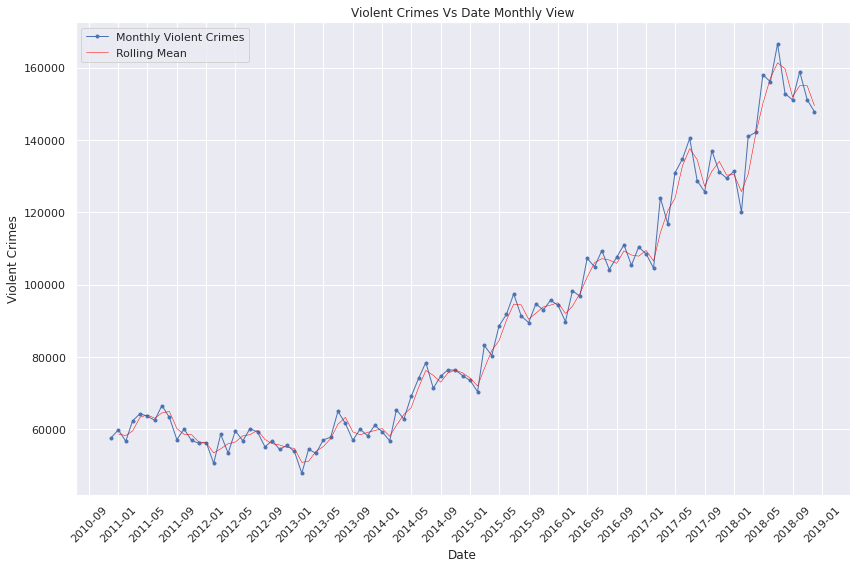

In [54]:
plt.figure(figsize=(12, 8))
# Compute the rolling mean
roll_mean = violent_crimes_pd2['Violent Crimes'].rolling(2).mean()
# Plot the original data using plt.plot()
plt.plot(violent_crimes_pd2.date, violent_crimes_pd2['Violent Crimes'],\
         marker='.', linestyle='-', linewidth=1, label='Monthly Violent Crimes')
# Plot the rolling mean on the same axis
plt.plot(violent_crimes_pd2.date, roll_mean, color='red', alpha=1, linewidth=0.5, label='Rolling Mean')
plt.title('Violent Crimes Vs Date Monthly View')
plt.ylabel('Violent Crimes')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate x-axis labels

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Set x-axis major ticks to 4-month intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))   # Format x-axis labels as 'YYYY-MM'
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.legend()
plt.show()

In [55]:
#Vectorizing the features
vector_assembler_2 = VectorAssembler(inputCols = ['Date_as_Integer_Norm'], outputCol = 'features_2')
vector_crime_df_2 = vector_assembler_2.transform(trainDF)

In [56]:
#Fit the linear regression model
lr_2 = LinearRegression(featuresCol = "features_2", labelCol = "Violent Crimes")
# Get the linear regression model from the pipeline
lr_model_2 = lr_2.fit(vector_crime_df_2)

In [57]:
#Creating the pipeline
pipeline_2 = Pipeline(stages = [vector_assembler_2, lr_2])
pipelineModel_2 = pipeline_2.fit(trainDF)

In [58]:
#Finding the slope and the intercept
slope_2 = lr_model_2.coefficients[0].round(2)
intercept_2 = round(lr_model_2.intercept,2)
print(f"""The formula for the linear regression line is
violent crime = {slope_2}*month + {intercept_2}""")

print(f"Slope (Coefficient for Months): {slope_2}")
print(f"Intercept: {intercept_2}")

if slope_2 > 0:
    print("There's an increasing trend in violent crimes over the years.")
else:
    print("There's a decreasing trend in violent crimes over the years.")

The formula for the linear regression line is
violent crime = 63202.71*month + 47398.76
Slope (Coefficient for Months): 63202.71
Intercept: 47398.76
There's an increasing trend in violent crimes over the years.


In [59]:
#Apply the pipeline transform method
predDF_2 = pipelineModel_2.transform(testDF)
predDF_2.show(5)

+----------+--------------+---------------+--------------------+--------------------+-----------------+
|     Month|Violent Crimes|Date_as_Integer|Date_as_Integer_Norm|          features_2|       prediction|
+----------+--------------+---------------+--------------------+--------------------+-----------------+
|2016-07-01|        109428|     1467331200|  0.6978097193702943|[0.6978097193702943]|91502.22554554066|
|2016-08-01|        104174|     1470009600|  0.7084188911704312|[0.7084188911704312]|92172.75398550153|
|2016-09-01|        107608|     1472688000|  0.7190280629705681|[0.7190280629705681]| 92843.2824254624|
|2016-10-01|        111037|     1475280000|  0.7292950034223135|[0.7292950034223135]|93492.18091574713|
|2016-11-01|        105340|     1477958400|  0.7399041752224503|[0.7399041752224503]|  94162.709355708|
+----------+--------------+---------------+--------------------+--------------------+-----------------+
only showing top 5 rows



In [60]:
#Evaluating the prediction
regressionEvaluator = RegressionEvaluator(
predictionCol="prediction",
labelCol="Violent Crimes",
metricName="rmse")
rmse_2 = regressionEvaluator.evaluate(predDF_2)
print(f"RMSE is {rmse_2:.1f}")

RMSE is 33066.0


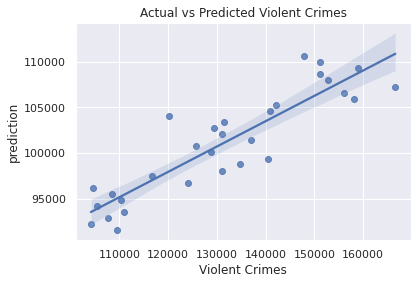

In [61]:
#use seaborn to get trendline
pandf_2 = predDF_2.select( "Violent Crimes", "prediction").toPandas()#Convert to pandas
ax_2 =sns.regplot(x= 'Violent Crimes', y='prediction', data = pandf_2)
ax_2.set_title('Actual vs Predicted Violent Crimes')
plt.show()

In [62]:
#Converting violent_crimes_yearly_2 to pandas for ease
pd_violent_crimes_yearly_2 = violent_crimes_yearly_2.toPandas()

# Assigning the column of the normalized dates to x_pred
x_pred = pd_violent_crimes_yearly_2["Date_as_Integer_Norm"]

# Calculate the prediction using the regression equation. We already have the slope and the intercept. 
# The 'month', or x, is the pd_violent_crimes_yearly_2["Date_as_Integer_Norm"] column
#As we can seem the model is not perfect by any menas, but the line is trending upwards, further confirming an increase in 
# violent crime
y_pred = slope_2 * x_pred + intercept_2

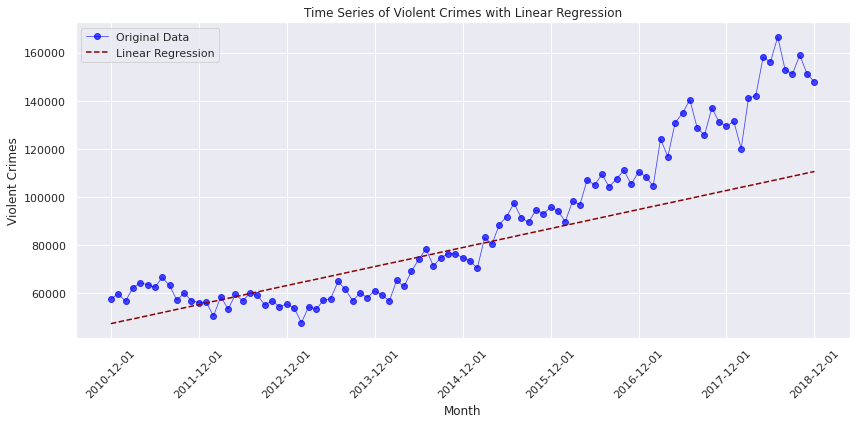

In [63]:
# Adjusting line appearance
plt.figure(figsize=(12, 6))
plt.plot(pd_violent_crimes_yearly_2["Month"], \
         pd_violent_crimes_yearly_2["Violent Crimes"], label="Original Data", color='blue', marker='o', linewidth=0.8, alpha=0.7)
plt.plot(pd_violent_crimes_yearly_2["Month"], \
         y_pred, label="Linear Regression", color='darkred', linestyle='--', linewidth=1.5)

# Setting every nth month to be displayed on the x-axis to avoid crowding
n = 12  # Display every 12th month (i.e., yearly)
ticks = pd_violent_crimes_yearly_2["Month"][::n]
plt.xticks(ticks, rotation=45)

plt.title("Time Series of Violent Crimes with Linear Regression")
plt.ylabel("Violent Crimes")
plt.xlabel("Month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Time Series analysis and forecast (2019 - 2021)

In [64]:
#Creating a df with dates and crime types from full data 
crime_timeframe_df_full = crime_data_df_full.select("Month", "Crime type")
crime_timeframe_df_full.show()

+-------+--------------------+
|  Month|          Crime type|
+-------+--------------------+
|2010-12|         Other crime|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|            Burglary|
|2010-12|            Burglary|
|2010-12|         Other crime|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|Anti-social behav...|
|2010-12|            Burglary|
|2010-12|            Burglary|
|2010-12|            Burglary|
|2010-12|            Burglary|
|2010-12|       Vehicle crime|
+-------+--------------------+
only showing top 20 rows



In [65]:
#Filtering all the crime types by keyword so as to isolate 'Violent' and 'Violence'
violent_crimes_df_full = \
crime_timeframe_df_full.filter((F.col("Crime type").contains('Violent')) | (F.col("Crime type").contains('Violence')))
violent_crimes_df_full.show(5)

+-------+-------------+
|  Month|   Crime type|
+-------+-------------+
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
|2010-12|Violent crime|
+-------+-------------+
only showing top 5 rows



In [66]:
# Format the 'Month' column to 'yyyy-MM-dd' 
violent_crimes_df_2_full = violent_crimes_df_full.withColumn("Month", date_format("Month", "yyyy-MM-dd"))

violent_crimes_df_2_full.show(5)

+----------+-------------+
|     Month|   Crime type|
+----------+-------------+
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 5 rows



In [67]:
# Group by Year and then count the amount of violent crimes per year so as to be able to create a time series analysys
violent_crimes_yearly_2_full = (violent_crimes_df_2_full
                         .groupBy(("Month"))
                         .count().withColumnRenamed("count", "Violent Crimes")
                         .orderBy("Month"))

violent_crimes_yearly_2_full.show(10)

+----------+--------------+
|     Month|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
+----------+--------------+
only showing top 10 rows



In [68]:
#Changing the Month column from string type to date type
violent_crimes_yearly_3_full = \
violent_crimes_yearly_2_full.select(to_date(col('Month'), "yyyy-MM-dd").alias('date'), 'Violent Crimes')
violent_crimes_yearly_3_full.show()

+----------+--------------+
|      date|Violent Crimes|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
|2011-10-01|         60076|
|2011-11-01|         56895|
|2011-12-01|         56163|
|2012-01-01|         56324|
|2012-02-01|         50598|
|2012-03-01|         58606|
|2012-04-01|         53415|
|2012-05-01|         59541|
|2012-06-01|         56816|
|2012-07-01|         60199|
+----------+--------------+
only showing top 20 rows



In [69]:
#Checking schema
violent_crimes_yearly_3_full.printSchema()

root
 |-- date: date (nullable = true)
 |-- Violent Crimes: long (nullable = false)



In [70]:
#Converting to pandas
violent_crimes_pd = violent_crimes_yearly_3_full.toPandas()
violent_crimes_pd.head(5)

,date,Violent Crimes
0,2010-12-01,57580
1,2011-01-01,59823
2,2011-02-01,56691
3,2011-03-01,62326
4,2011-04-01,64299


In [71]:
#Convert the "date" column of the violent_crimes_pd dataframe into a datetime format
#Set the "date" column as the index of the dataframe
violent_crimes_pd.date = violent_crimes_pd.date.astype('datetime64[ns]')
violent_crimes_pd2 = violent_crimes_pd.set_index(pd.to_datetime(violent_crimes_pd.date))
violent_crimes_pd2.head(5)

,date,Violent Crimes
date,,
2010-12-01,2010-12-01,57580
2011-01-01,2011-01-01,59823
2011-02-01,2011-02-01,56691
2011-03-01,2011-03-01,62326
2011-04-01,2011-04-01,64299


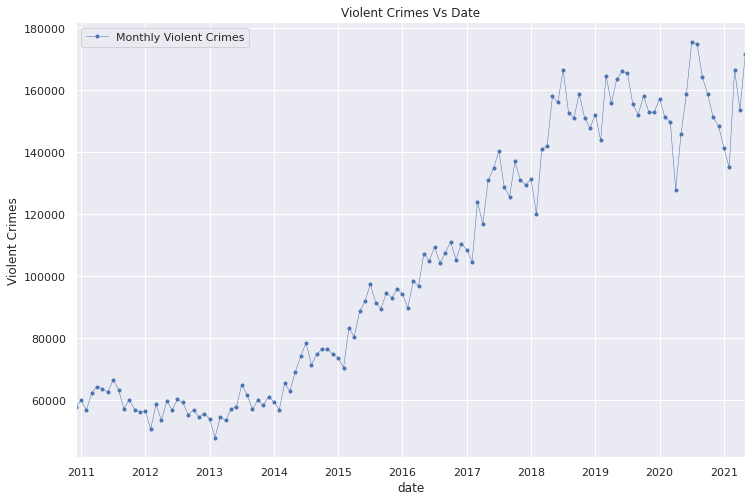

In [72]:
#Plotting complete time series up until 2021
violent_crimes_pd2.plot(y='Violent Crimes', x='date',marker='.', linestyle='-', linewidth=0.5,\
subplots=False,
label='Monthly Violent Crimes', figsize=(12,8),
title='Violent Crimes Vs Date')
plt.ylabel('Violent Crimes')
plt.show()

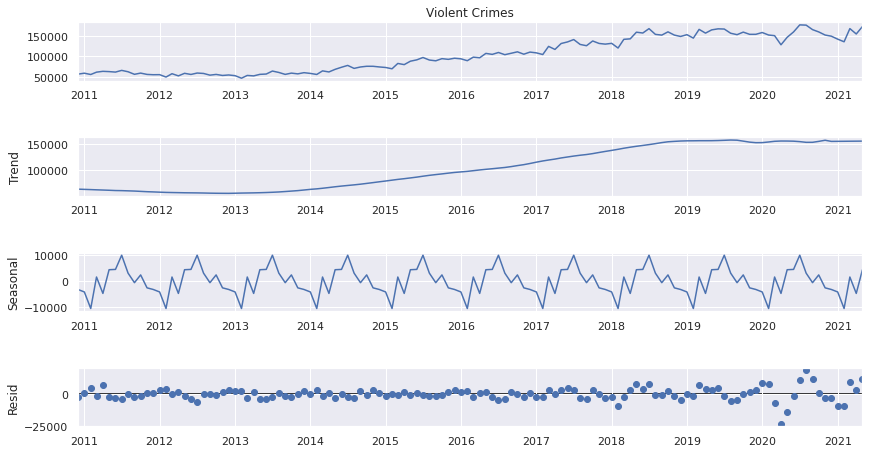

In [73]:
#Decomposing the plot into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(violent_crimes_pd2['Violent Crimes'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [74]:
#Subset of the data taken in order to bypass the disconinuity presented from 2010 to 2015 and from 2016 to 2021.. 
#...as seen in the plot above. This will also facilitare stationarity later on, as it cannot be achieved with the full dataset
violent_crimes_pd3 = violent_crimes_pd2[(violent_crimes_pd2.date.dt.year > 2015) ] 
violent_crimes_pd3.head(5)

,date,Violent Crimes
date,,
2016-01-01,2016-01-01,94278
2016-02-01,2016-02-01,89779
2016-03-01,2016-03-01,98294
2016-04-01,2016-04-01,96798
2016-05-01,2016-05-01,107262


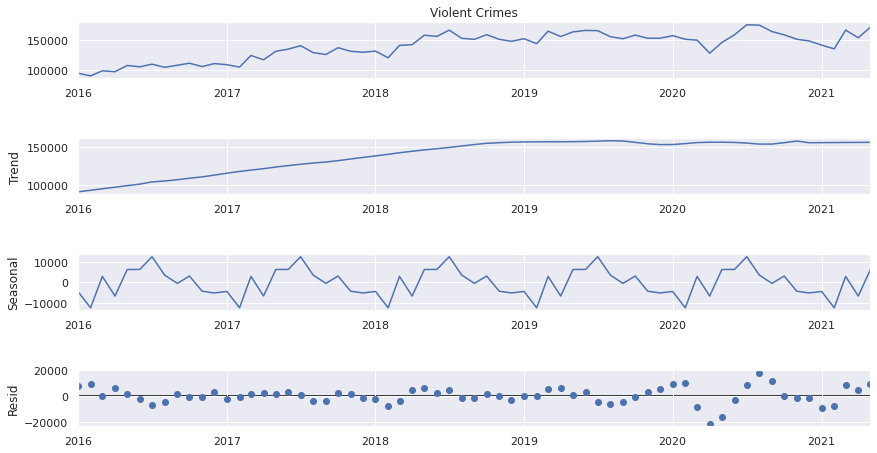

In [75]:
#Decomposing the plot into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(violent_crimes_pd3['Violent Crimes'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [76]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
  print(' > Is the {} stationary ?'.format(dataDesc))
  dftest = adfuller(timeseries.dropna(), autolag='AIC')
  print('Test statistic = {:.3f}'.format(dftest[0]))
  print('P-value = {:.3f}'.format(dftest[1]))
  print('Critical values :')
  for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [77]:
#Applying test to the Violent Crimes column
#The data seems to be already stationary without having to apply detrending or differencing
ADF_test(violent_crimes_pd3['Violent Crimes'],'raw data')

 > Is the raw data stationary ?
Test statistic = -3.004
P-value = 0.035
Critical values :
	1%: -3.560242358792829 - The data is not stationary with 99% confidence
	5%: -2.9178502070837 - The data is  stationary with 95% confidence
	10%: -2.5967964150943397 - The data is  stationary with 90% confidence


In [78]:
#Saving the file
violent_crimes_pd3[['date', 'Violent Crimes']].to_csv("stationary_violent_crimes.csv", header=True, index=False)

In [79]:
#Reading the file
file = "stationary_violent_crimes.csv"
vc2 = pd.read_csv(file, parse_dates=['date'])
vc2.head(5)

,date,Violent Crimes
0,2016-01-01,94278
1,2016-02-01,89779
2,2016-03-01,98294
3,2016-04-01,96798
4,2016-05-01,107262


In [80]:
vc2.date = vc2.date.astype('datetime64[ns]')
# Setting the 'date' column as the index, dropping rows with NaN, and selecting the 'Violent Crimes' column
y_vc = vc2.set_index(pd.to_datetime(vc2.date)).dropna()["Violent Crimes"]
# Display the first 5 rows
y_vc.head(5)

date
2016-01-01     94278
2016-02-01     89779
2016-03-01     98294
2016-04-01     96798
2016-05-01    107262
Name: Violent Crimes, dtype: int64

In [81]:
#Setting up the train data (all the way up to the end of 2018 to be in line with the TV documentary's claim)...
#...and the test data, which goes all the way to 2021
y_vc_to_train = y_vc[:'2018-12-01'] # dataset to train
y_vc_to_test = y_vc['2019-01-01': ] # last X months for test
y_vc_to_val = y_vc_to_test

In [82]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
p = d = q = range(0, 2) #defining ranges for parameters for the ARIMA model. Each can take a value from 0 to 1
seasonal_period = 12 #Setting seasonal period
#Creating all possible combinations of the parameters p, d, and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [83]:
#Finding the best combination of parameters for a time series forecasting model(SARIMAX)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_vc_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:950.5940476686084
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:944.4458822184091
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:552.0878309613606
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:536.4436106475507
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.067980714225
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:863.393247707313
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:524.7259432832614
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:473.3931100248616
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:930.1815691056606
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:929.9600777608734
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:543.0589453897956
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:541.3940228053514
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:929.2147606474274
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:931.151844389614
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:539.3125735818074
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:536.4618638674738
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:735.8132077899459
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:735.7515913126805
ARIMA(0, 1, 0

In [84]:
order = (0, 1, 0) #Using the optimal values from the previous step
seasonal_order = (0, 1, 0, 12)
model = sm.tsa.statespace.SARIMAX(y_vc_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

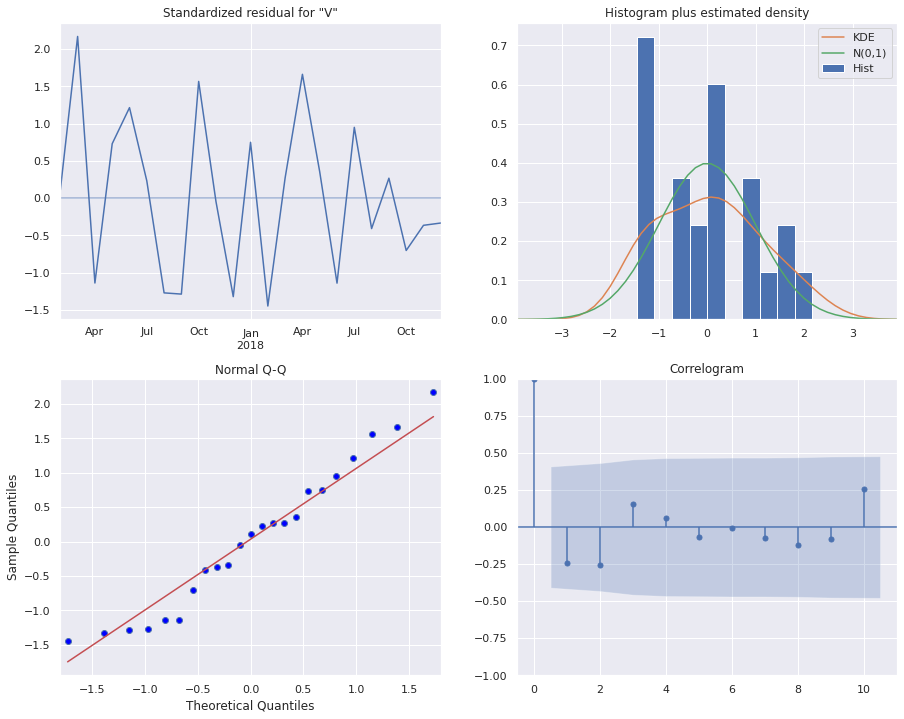

In [85]:
#Plotting the results
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [86]:
pred_uc = results.get_forecast(steps=29) #predicting the next 29 data points (violent crime rates for the next 29 months)
pred_ci = pred_uc.conf_int() #Calculating the confidence interval for the forecast

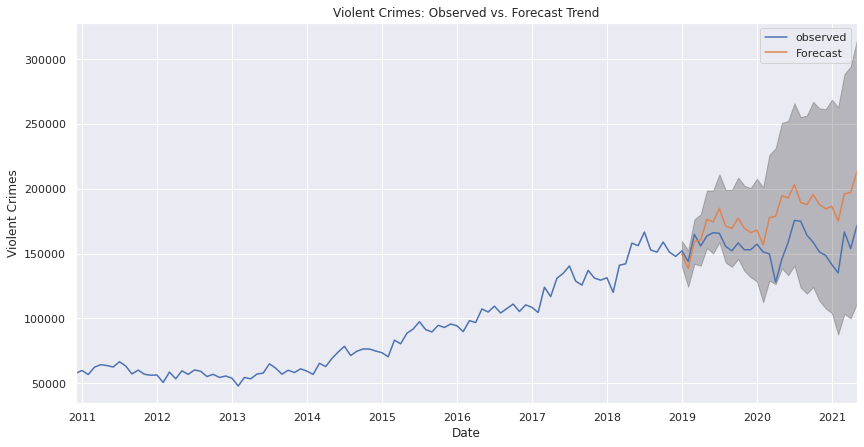

In [87]:
#Plotting the observed line and the forecast + confidence interval
#ax = y_vc.plot(label='observed', figsize=(14, 7))
ax = violent_crimes_pd2['Violent Crimes'].plot(label='observed', figsize=(14, 7))

#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Violent Crimes: Observed vs. Forecast Trend')
ax.set_xlabel('Date')
ax.set_ylabel(y_vc.name)

plt.legend()
plt.show()

In [88]:
# Producing the forcasted tables
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table.head(12)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2019-01-01,149714.00000000,139798.59869917,159629.40130083
1,2019-02-01,138437.00000000,124414.50500400,152459.49499600
2,2019-03-01,159311.00000000,142137.02116953,176484.97883047
3,2019-04-01,160460.00000000,140629.19739834,180290.80260166
4,2019-05-01,176402.00000000,154230.48866716,198573.51133284
5,2019-06-01,174434.00000000,150146.32621804,198721.67378196
6,2019-07-01,184921.00000000,158687.31400860,211154.68599140
7,2019-08-01,171168.00000000,143123.01000799,199212.98999201
8,2019-09-01,169441.00000000,139694.79609751,199187.20390249
9,2019-10-01,177241.00000000,145885.74797478,208596.25202522


In [89]:
# Producing the test data prediction values
y_vc_to_test.head(30)

date
2019-01-01    152116
2019-02-01    143884
2019-03-01    164799
2019-04-01    155840
2019-05-01    163627
2019-06-01    166106
2019-07-01    165612
2019-08-01    155557
2019-09-01    152110
2019-10-01    158257
2019-11-01    152923
2019-12-01    152970
2020-01-01    157274
2020-02-01    151260
2020-03-01    149773
2020-04-01    127901
2020-05-01    145837
2020-06-01    158701
2020-07-01    175562
2020-08-01    174980
2020-09-01    164204
2020-10-01    158725
2020-11-01    151251
2020-12-01    148517
2021-01-01    141414
2021-02-01    135101
2021-03-01    166668
2021-04-01    153789
2021-05-01    171614
Name: Violent Crimes, dtype: int64

In [90]:
# Calculate RMSE
rmse = mean_squared_error(y_vc_to_test[:29], pred_uc.predicted_mean, squared=False)
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 27991.15981630752


In [91]:
# Calculate MAE
mae = mean_absolute_error(y_vc_to_test[:29], pred_uc.predicted_mean)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 23878.068965517243


In [92]:
#Calculate MAPE
mape = np.mean(np.abs((y_vc_to_test[:29] - pred_uc.predicted_mean) / y_vc_to_test[:24])) * 100
print('Mean Absolute Percentage Error:', mape, '%')

Mean Absolute Percentage Error: 13.458041901187572 %


In [93]:
# Filter for firearm incidents
firearm_incidents_df = crime_data_df.filter(
    (crime_data_df["Crime type"] == "Possession of weapons") &
    (crime_data_df["Last outcome category"] == "Offender sent to prison")
)

firearm_incidents_df.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|Year|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|0b3b9b6734d5d39e0...|2013-05|Avon and Somerset...|Avon and Somerset...|-2.595297|51.490694|On or near Wellin...|E01014636|Bristol 004D|Possession of wea...| Offender sent to ...|   null|2013|
|847bb34d1477d850d...|2013-05|Avon and Somerset...|Avon and Somerset...| -2.51668|51.476465|On or near Briar ...|E01014629|Bristol 018D|Possession of wea...| Offender sent to ...|   null|2013|
|1de0400a0b6d75375...|2013-05|Avon 

In [94]:
firearm_incidents_df.count() #Counting the number of rows in this new filtered dataframe

9966

In [95]:
#Checking how many rows have missing LSOA code values which will be needed later to join dfs
#The lsoa_pop_df has no missing LSAO Codes as seen from Section 3 above 
firearm_incidents_df.select([count(when(col(c).isNull(), c)).alias(c) for c in firearm_incidents_df.columns]).show()

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category|Context|Year|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----+
|       0|    0|          0|           0|      285|     285|       0|      285|      285|         0|                    0|   9966|   0|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+----+



In [96]:
#Even though the inner join later would ave taken care of exclusing the rows with missing LSOA code, for the sake of clarity...
#..the small percentage of rows (2.86%) with missing LSAO codes that would not have matched anyway will be removed 
cleaned_firearm_incidents_df = firearm_incidents_df.na.drop(subset = ['LSOA code'])
cleaned_firearm_incidents_df.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|Year|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|0b3b9b6734d5d39e0...|2013-05|Avon and Somerset...|Avon and Somerset...|-2.595297|51.490694|On or near Wellin...|E01014636|Bristol 004D|Possession of wea...| Offender sent to ...|   null|2013|
|847bb34d1477d850d...|2013-05|Avon and Somerset...|Avon and Somerset...| -2.51668|51.476465|On or near Briar ...|E01014629|Bristol 018D|Possession of wea...| Offender sent to ...|   null|2013|
|1de0400a0b6d75375...|2013-05|Avon 

In [97]:
# Renaming the LSOA name column
cleaned_firearm_incidents_df = cleaned_firearm_incidents_df.withColumnRenamed('LSOA name', "LSOA_name")
cleaned_firearm_incidents_df.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA_name|          Crime type|Last outcome category|Context|Year|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+
|0b3b9b6734d5d39e0...|2013-05|Avon and Somerset...|Avon and Somerset...|-2.595297|51.490694|On or near Wellin...|E01014636|Bristol 004D|Possession of wea...| Offender sent to ...|   null|2013|
|847bb34d1477d850d...|2013-05|Avon and Somerset...|Avon and Somerset...| -2.51668|51.476465|On or near Briar ...|E01014629|Bristol 018D|Possession of wea...| Offender sent to ...|   null|2013|
|1de0400a0b6d75375...|2013-05|Avon 

In [98]:
#Checking to see if all the district names in the lsoa data set have a 4 alphanumeric code at the end which is separated 
#by a space from the city name.
#At first glance, they all seem to have an OA code of only 4 digits. However we can dig deeper
lsoa_pop_df.select("geography").distinct().show(50)

+--------------------+
|           geography|
+--------------------+
|     Darlington 009A|
|      Gateshead 018A|
| North Tyneside 002D|
|      Blackpool 010D|
|      Blackpool 014B|
|  Cheshire East 040A|
|Cheshire West and...|
|       Rochdale 025G|
|      Stockport 008B|
|      Stockport 036D|
|      Stockport 037C|
|       Tameside 029D|
|       Trafford 008B|
|        Chorley 011D|
|West Lancashire 014D|
|      Liverpool 044D|
|      Liverpool 051D|
|     St. Helens 007F|
|         Wirral 004E|
|         Wirral 036B|
|East Riding of Yo...|
|North Lincolnshir...|
|         Craven 004A|
|       Barnsley 002A|
|      Doncaster 009A|
|      Doncaster 019A|
|      Doncaster 035E|
|      Sheffield 039E|
|      Sheffield 074C|
|      Sheffield 074D|
|       Bradford 039G|
|       Bradford 042B|
|       Bradford 051D|
|     Calderdale 002D|
|     Calderdale 014C|
|          Leeds 032C|
|          Leeds 041B|
|          Leeds 076B|
|          Leeds 085B|
|          Leeds 086A|
|          

In [99]:
# Extracting the last 5 characters (4 OA + 1 space) as well as the city names and creating two extra columns
lsoa_pop_extracted_df = lsoa_pop_df.withColumn("city_name", F.expr("substring(geography, 1, length(geography)-5)"))
lsoa_pop_extracted_df = lsoa_pop_extracted_df.withColumn('OA', F.expr("substring(geography, length(geography)-4, 5)"))
lsoa_pop_extracted_df.show(10)

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+----------+-----+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value| c

In [100]:
# Filtering rows where the OA does not match the expected pattern: a space followed by 4 alphanumeric characters
incorrect_OAs = lsoa_pop_extracted_df.filter(~lsoa_pop_extracted_df['OA'].rlike(" [A-Za-z0-9]{4}"))
# Displaying distinct incorrect 'geography' rows to inspect and confirm that the OA column only has OAs 
#comprised of 4 alphanumeric characters PLUS a space in front of them
incorrect_OAs.select("geography").distinct().show(50)

+---------+
|geography|
+---------+
+---------+



In [101]:
#Doing the same with the firearm_incidents_df
firearm_incidents_extracted_df = firearm_incidents_df.withColumn("city_name", \
                                                                 F.expr("substring('LSOA name', 1, length('LSOA name')-5)"))
firearm_incidents_extracted_df = firearm_incidents_extracted_df.withColumn('OA', \
                                                                F.expr("substring('LSOA name', length('LSOA name')-4, 5)"))
incorrect_OAs = firearm_incidents_extracted_df.filter(~firearm_incidents_extracted_df['OA'].rlike(" [A-Za-z0-9]{4}"))
incorrect_OAs.select("LSOA name").distinct().show(50)

# Both dataframe created have 0 rows whhere the OA does not 
# match the expected pattern: a space followed by 4 alphanumeric characters

+---------+
|LSOA name|
+---------+
+---------+



In [102]:
# Extract the city name from the geography column (by removing the last 5 
#characters since those are standard in all the cty names (4 characters plusa space))
firearm_incidents_with_cityname = cleaned_firearm_incidents_df.withColumn("city_name", \
                                                                        F.expr("substring(LSOA_name, 1, length(LSOA_name)-5)"))
firearm_incidents_with_cityname.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+---------+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA_name|          Crime type|Last outcome category|Context|Year|city_name|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+----+---------+
|0b3b9b6734d5d39e0...|2013-05|Avon and Somerset...|Avon and Somerset...|-2.595297|51.490694|On or near Wellin...|E01014636|Bristol 004D|Possession of wea...| Offender sent to ...|   null|2013|  Bristol|
|847bb34d1477d850d...|2013-05|Avon and Somerset...|Avon and Somerset...| -2.51668|51.476465|On or near Briar ...|E01014629|Bristol 018D|Possession of wea...| Offender sent to ...|   null|2

In [103]:
# Group by the extracted city name and count the incidents
firearm_incidents_city_agg = firearm_incidents_with_cityname.groupBy("city_name").count().withColumnRenamed("count", \
                                                                                                             "incident_count")
firearm_incidents_city_agg.show(5)

+--------------+--------------+
|     city_name|incident_count|
+--------------+--------------+
|     Worcester|            36|
|     Charnwood|            10|
|North Kesteven|             4|
| Epping Forest|             9|
|          Arun|            14|
+--------------+--------------+
only showing top 5 rows



In [104]:
# Similarly, extract city name for the population data and group by it
lsoa_pop_df = lsoa_pop_df.withColumn("city_name", F.expr("substring(geography, 1, length(geography)-5)"))
lsoa_pop_df.show(5)

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+----------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value| city_na

In [105]:
# Sum up the population of every city and group by city so as to have a total population for every single city
city_population_agg = lsoa_pop_df.groupBy("city_name").\
agg(F.sum("Variable: All usual residents; measures: Value").alias("total_population"))
city_population_agg.show(5)

+--------------+----------------+
|     city_name|total_population|
+--------------+----------------+
|     Worcester|           98768|
|     Charnwood|          166100|
|North Kesteven|          107766|
| Epping Forest|          124659|
|       Waveney|          115254|
+--------------+----------------+
only showing top 5 rows



In [106]:
# Join the two aggregated dataframes based on city_name
combined_city_df = firearm_incidents_city_agg.join(city_population_agg, "city_name")
combined_city_df.show(5)

+--------------+--------------+----------------+
|     city_name|incident_count|total_population|
+--------------+--------------+----------------+
|     Worcester|            36|           98768|
|     Charnwood|            10|          166100|
|North Kesteven|             4|          107766|
| Epping Forest|             9|          124659|
|          Arun|            14|          149518|
+--------------+--------------+----------------+
only showing top 5 rows



In [107]:
# Calculate incidents per head for each city by dividing the incident count by the total population of each city
combined_city_df = combined_city_df.withColumn(
    "incidents_per_head",
    combined_city_df["incident_count"] / combined_city_df["total_population"]
)
combined_city_df.show(5)

+--------------+--------------+----------------+--------------------+
|     city_name|incident_count|total_population|  incidents_per_head|
+--------------+--------------+----------------+--------------------+
|     Worcester|            36|           98768|3.644905232463955...|
|     Charnwood|            10|          166100|6.020469596628537E-5|
|North Kesteven|             4|          107766|3.711745819646271E-5|
| Epping Forest|             9|          124659|7.219695328857122E-5|
|          Arun|            14|          149518|9.363421126553324E-5|
+--------------+--------------+----------------+--------------------+
only showing top 5 rows



In [108]:
# Get the city with the highest incidents per head
highest_incidents_city = combined_city_df.orderBy(F.desc("incidents_per_head")).first()
highest_incidents_city

Row(city_name='City of London', incident_count=17, total_population=7375, incidents_per_head=0.0023050847457627118)

In [109]:
# Filter out the row for Birmingham
birmingham_row = combined_city_df.filter(combined_city_df["city_name"].contains("Birmingham")).first()
birmingham_row

Row(city_name='Birmingham', incident_count=227, total_population=1073045, incidents_per_head=0.00021154751198691575)

In [110]:
print("City with the highest firearm incidents per head:", highest_incidents_city["city_name"], \
      highest_incidents_city["incidents_per_head"])
print("Incidents per head for Birmingham:", birmingham_row["incidents_per_head"])
#Clearly there are NOT more firearm incidents per head in Birmingham compared with anywhere else in the UK

City with the highest firearm incidents per head: City of London 0.0023050847457627118
Incidents per head for Birmingham: 0.00021154751198691575


In [111]:
#Converting the dataframe to pandas to be able to visualize the differences in firearm incidents
combined_city_pd = combined_city_df.toPandas()
combined_city_pd.head(5)

,city_name,incident_count,total_population,incidents_per_head
0,Worcester,36,98768,0.00036449
1,Charnwood,10,166100,0.00006020
2,North Kesteven,4,107766,0.00003712
3,Epping Forest,9,124659,0.00007220
4,Arun,14,149518,0.00009363


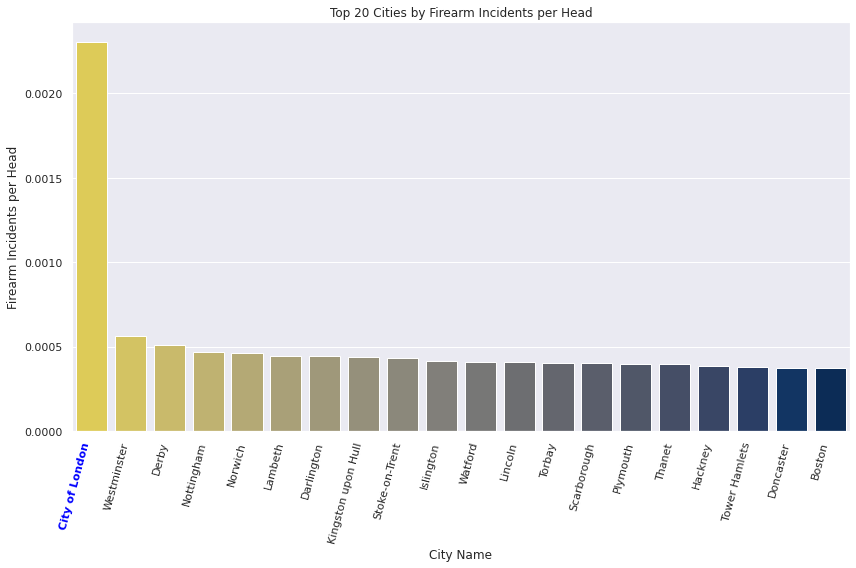

In [112]:
# Filter to get top 20 cities (Top city colored in blue for visibility)
top_cities = combined_city_pd.sort_values(by="incidents_per_head", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_cities, x="city_name", y="incidents_per_head", palette="cividis_r")
plt.xlabel("City Name")
plt.ylabel("Firearm Incidents per Head")
plt.title("Top 20 Cities by Firearm Incidents per Head")
plt.xticks(rotation=75, ha = 'right')
plt.gca().get_xticklabels()[0].set_color('blue')
plt.gca().get_xticklabels()[0].set_weight('bold')
plt.tight_layout()
plt.show()

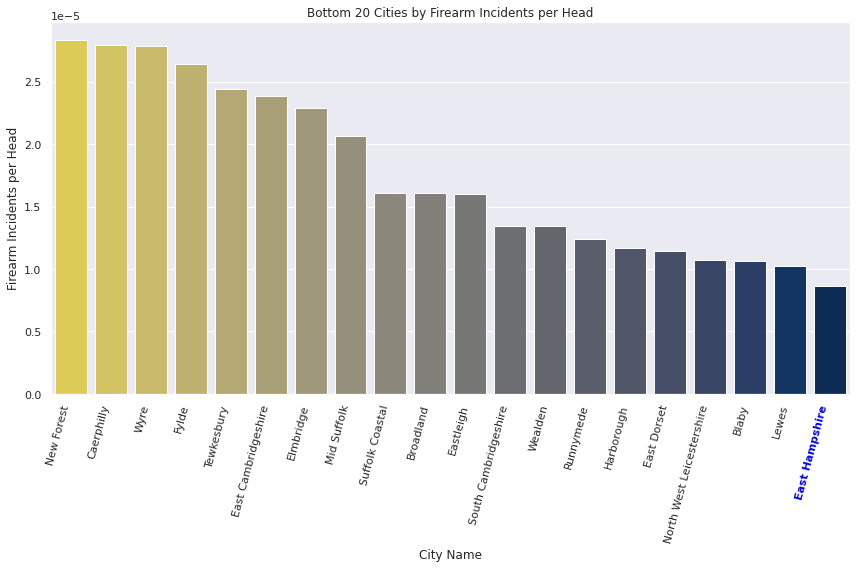

In [113]:
# Filter to get bottom 20 cities (Bottom city colored in blue for visibility)
bottom_cities = combined_city_pd.sort_values(by="incidents_per_head", ascending=False).tail(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=bottom_cities, x="city_name", y="incidents_per_head", palette="cividis_r")
plt.xlabel("City Name")
plt.ylabel("Firearm Incidents per Head")
plt.title("Bottom 20 Cities by Firearm Incidents per Head")
plt.xticks(rotation=75, ha = 'right')
plt.gca().get_xticklabels()[19].set_color('blue')
plt.gca().get_xticklabels()[19].set_weight('bold')
plt.tight_layout()
plt.show()

In [114]:
#Calculating the percent rank for each city
#Ensuring that the data is ordered by the incidents_per_head column
window = Window.orderBy("incidents_per_head").rowsBetween(
    Window.unboundedPreceding, Window.currentRow)
city_rank = combined_city_df.withColumn('percent_rank', percent_rank().over(window))
city_rank.show(10)

+--------------------+--------------+----------------+--------------------+--------------------+
|           city_name|incident_count|total_population|  incidents_per_head|        percent_rank|
+--------------------+--------------+----------------+--------------------+--------------------+
|      East Hampshire|             1|          115608|8.649920420732129E-6|                 0.0|
|               Lewes|             1|           97502|1.025619987282312...|0.002976190476190476|
|               Blaby|             1|           93915|1.064792631634989E-5|0.005952380952380952|
|North West Leices...|             1|           93468|1.069884880386870...|0.008928571428571428|
|         East Dorset|             1|           87166|1.147236307734667...|0.011904761904761904|
|          Harborough|             1|           85382|1.171207045981588...| 0.01488095238095238|
|           Runnymede|             1|           80510|1.242081728977766...|0.017857142857142856|
|             Wealden|        

In [115]:
#Filtering out the row corresponding to Birmingham to see its rank
birmingham_percentile = city_rank.filter(city_rank['city_name'] == 'Birmingham').collect()[0]['percent_rank']
print(f"The percentile rank for Birmingham is: {birmingham_percentile*100:.2f}%")

The percentile rank for Birmingham is: 74.40%


In [116]:
#Counting the distinct number of cities
total_cities = firearm_incidents_city_agg.select("city_name").distinct().count()
total_cities

337

In [117]:
# Calculate Birmingham's position using its percentile rank
birmingham_position = round(total_cities - (birmingham_percentile * total_cities))
print(f"Birmingham is ranked {birmingham_position} out of {total_cities}.")

Birmingham is ranked 86 out of 337.


In [118]:
#Calculating the mean and standard deviation of the firearm incidents from the combined_cities_ps Pandas database
mean_incidents = combined_city_pd['incidents_per_head'].mean()
std_dev_incidents = combined_city_pd['incidents_per_head'].std()
print(f"The mean firearm incidents is: {mean_incidents}.")
print(f"The standard deviation firearm incidents is: {std_dev_incidents}.")

The mean firearm incidents is: 0.00015810535215770265.
The standard deviation firearm incidents is: 0.00016048696955077552.


In [119]:
#Finding the value of Birmingham incidents per head
birmingham_incidents = combined_city_pd[combined_city_pd['city_name'] == 'Birmingham']['incidents_per_head'].values[0]
print(f"The number of firearm incidents in Birmingham is: {birmingham_incidents}.")

The number of firearm incidents in Birmingham is: 0.00021154751198691575.


In [120]:
#Calculating the z-score
z_score_birmingham = (birmingham_incidents - mean_incidents) / std_dev_incidents
print(f"The Z-score for Birmingham is: {z_score_birmingham:.2f}")

The Z-score for Birmingham is: 0.33


### Temporal analysis to determine a general trend over the months/years suggesting a close association between drug crimes and gun crimes (when one is higher, is the other one also higher?)

#### Monthly analysis to verify the yearly one (removing any data before 2013-06-30). Removing anything prior to 2013-06-30 since, accordng to https://data.police.uk/changelog/, the definition of firearm crimes we are using for this report (Possession of a weapon) did not exist before then. So taking that data into consideration would skew the results

In [121]:
#Filtering the original fataframe so as to only have the 3 columns needed
firearm_crimes_df = firearm_incidents_df.select(F.col("Month"), F.col("Crime Type"), F.col("Last outcome category"))
firearm_crimes_df.show(5)

+-------+--------------------+---------------------+
|  Month|          Crime Type|Last outcome category|
+-------+--------------------+---------------------+
|2013-05|Possession of wea...| Offender sent to ...|
|2013-05|Possession of wea...| Offender sent to ...|
|2013-05|Possession of wea...| Offender sent to ...|
|2013-05|Possession of wea...| Offender sent to ...|
|2013-05|Possession of wea...| Offender sent to ...|
+-------+--------------------+---------------------+
only showing top 5 rows



In [122]:
# Group by Year and then count the amount of firearm crimes per year so as to be able to create a time series analysys
firearm_crimes_yearly = (firearm_crimes_df
                         .groupBy("Month")
                         .count().withColumnRenamed("count","Firearm incidents")
                         .orderBy("Month"))

firearm_crimes_yearly = firearm_crimes_yearly.withColumn("Month", date_format("Month", "yyyy-MM-dd"))
firearm_crimes_yearly.show()

+----------+-----------------+
|     Month|Firearm incidents|
+----------+-----------------+
|2013-05-01|              182|
|2013-06-01|              162|
|2013-07-01|              161|
|2013-08-01|              186|
|2013-09-01|              174|
|2013-10-01|              159|
|2013-11-01|              156|
|2013-12-01|              149|
|2014-01-01|              162|
|2014-02-01|              121|
|2014-03-01|              143|
|2014-04-01|              156|
|2014-05-01|              137|
|2014-06-01|              164|
|2014-07-01|              175|
|2014-08-01|              155|
|2014-09-01|              146|
|2014-10-01|              154|
|2014-11-01|              123|
|2014-12-01|              115|
+----------+-----------------+
only showing top 20 rows



In [123]:
#Filtering all the crime types by keyword so as to isolate 'Drugs'
drug_crimes_df = crime_timeframe.filter((F.col("Crime type").contains('Drugs')))

drug_crimes_df.show(5)

+-------+----------+
|  Month|Crime type|
+-------+----------+
|2011-09|     Drugs|
|2011-09|     Drugs|
|2011-09|     Drugs|
|2011-09|     Drugs|
|2011-09|     Drugs|
+-------+----------+
only showing top 5 rows



In [124]:
# Group by Year and then count the amount of drug crimes per year so as to be able to create a time series analysys
drug_crimes_yearly = (drug_crimes_df
                         .groupBy("Month")
                         .count().withColumnRenamed("count","Drug incidents")
                         .orderBy("Month"))
drug_crimes_yearly = drug_crimes_yearly.withColumn("Month", date_format("Month", "yyyy-MM-dd"))
drug_crimes_yearly.show()

+----------+--------------+
|     Month|Drug incidents|
+----------+--------------+
|2011-09-01|         16926|
|2011-10-01|         18448|
|2011-11-01|         18267|
|2011-12-01|         17366|
|2012-01-01|         18199|
|2012-02-01|         16710|
|2012-03-01|         19025|
|2012-04-01|         16047|
|2012-05-01|         17572|
|2012-06-01|         16989|
|2012-07-01|         18958|
|2012-08-01|         18827|
|2012-09-01|         16435|
|2012-10-01|         16534|
|2012-11-01|         16740|
|2012-12-01|         16075|
|2013-01-01|         16818|
|2013-02-01|         15854|
|2013-03-01|         17237|
|2013-04-01|         16489|
+----------+--------------+
only showing top 20 rows



In [125]:
#Joining the dataframe with drug data with the dataframe with firearm data by their common 'Year" column
drugs_and_firearms_df = \
drug_crimes_yearly.join(firearm_crimes_yearly, firearm_crimes_yearly.Month == drug_crimes_yearly.Month, "full")
drugs_and_firearms_df.show()

+----------+--------------+----------+-----------------+
|     Month|Drug incidents|     Month|Firearm incidents|
+----------+--------------+----------+-----------------+
|2015-05-01|         12633|2015-05-01|              117|
|2014-11-01|         13993|2014-11-01|              123|
|2017-10-01|         12367|2017-10-01|              141|
|2014-05-01|         15359|2014-05-01|              137|
|2017-11-01|         12198|2017-11-01|              116|
|2015-09-01|         12018|2015-09-01|              193|
|2014-07-01|         14854|2014-07-01|              175|
|2015-11-01|         12264|2015-11-01|              167|
|2017-12-01|         11264|2017-12-01|               97|
|2018-01-01|         12082|2018-01-01|               95|
|2016-04-01|         11997|2016-04-01|              144|
|2016-12-01|         11223|2016-12-01|              166|
|2015-01-01|         13423|2015-01-01|              155|
|2014-08-01|         14265|2014-08-01|              155|
|2011-11-01|         18267|    

In [126]:
#Converting to Pandas
drugs_and_firearm_pd = drugs_and_firearms_df.toPandas()
drugs_and_firearm_pd.head(10)

,Month,Drug incidents,Month,Firearm incidents
0,2015-05-01,12633,2015-05-01,117.00000000
1,2014-11-01,13993,2014-11-01,123.00000000
2,2017-10-01,12367,2017-10-01,141.00000000
3,2014-05-01,15359,2014-05-01,137.00000000
4,2017-11-01,12198,2017-11-01,116.00000000
5,2015-09-01,12018,2015-09-01,193.00000000
6,2014-07-01,14854,2014-07-01,175.00000000
7,2015-11-01,12264,2015-11-01,167.00000000
8,2017-12-01,11264,2017-12-01,97.00000000
9,2018-01-01,12082,2018-01-01,95.00000000


In [127]:
#Removing the duplicate 'month' column
drugs_and_firearm_pd = drugs_and_firearm_pd.loc[:, ~drugs_and_firearm_pd.columns.duplicated()]
drugs_and_firearm_pd.head(10)

,Month,Drug incidents,Firearm incidents
0,2015-05-01,12633,117.00000000
1,2014-11-01,13993,123.00000000
2,2017-10-01,12367,141.00000000
3,2014-05-01,15359,137.00000000
4,2017-11-01,12198,116.00000000
5,2015-09-01,12018,193.00000000
6,2014-07-01,14854,175.00000000
7,2015-11-01,12264,167.00000000
8,2017-12-01,11264,97.00000000
9,2018-01-01,12082,95.00000000


In [128]:
# Convert the 'Month' column to datetime format
drugs_and_firearm_pd['Month'] = pd.to_datetime(drugs_and_firearm_pd['Month'])

# Filter rows based on the 'Month' value
filtered_df = drugs_and_firearm_pd[drugs_and_firearm_pd['Month'] > '2013-05-30']

# Display the filtered dataframe
filtered_df.head()

,Month,Drug incidents,Firearm incidents
0,2015-05-01,12633,117.00000000
1,2014-11-01,13993,123.00000000
2,2017-10-01,12367,141.00000000
3,2014-05-01,15359,137.00000000
4,2017-11-01,12198,116.00000000


In [129]:
#Replacing te NaN values with 0s. NaN values can give a skewed correlation result and
# I have decided that any year that has no firearm incident should have a 0 since the incident either
# did not happen or did not result inmeeting the criteria for firearm incident (meaning the offender did not go to prison)
drugs_and_firearm_pd_modified = filtered_df.fillna(0)
drugs_and_firearm_pd_modified.head(10)

,Month,Drug incidents,Firearm incidents
0,2015-05-01,12633,117.00000000
1,2014-11-01,13993,123.00000000
2,2017-10-01,12367,141.00000000
3,2014-05-01,15359,137.00000000
4,2017-11-01,12198,116.00000000
5,2015-09-01,12018,193.00000000
6,2014-07-01,14854,175.00000000
7,2015-11-01,12264,167.00000000
8,2017-12-01,11264,97.00000000
9,2018-01-01,12082,95.00000000


In [130]:
# Convert the 'Month' column to datetime format
#drugs_and_firearm_pd_modified['Month'] = pd.to_datetime(drugs_and_firearm_pd_modified['Month'])

# Extract the year and create a new 'Year' column
drugs_and_firearm_pd_modified['Year'] = drugs_and_firearm_pd_modified['Month'].dt.year

drugs_and_firearm_pd_modified.head(10)

,Month,Drug incidents,Firearm incidents,Year
0,2015-05-01,12633,117.00000000,2015
1,2014-11-01,13993,123.00000000,2014
2,2017-10-01,12367,141.00000000,2017
3,2014-05-01,15359,137.00000000,2014
4,2017-11-01,12198,116.00000000,2017
5,2015-09-01,12018,193.00000000,2015
6,2014-07-01,14854,175.00000000,2014
7,2015-11-01,12264,167.00000000,2015
8,2017-12-01,11264,97.00000000,2017
9,2018-01-01,12082,95.00000000,2018


In [131]:
#Pearson's correlation 
correlation = drugs_and_firearm_pd_modified["Drug incidents"].corr(drugs_and_firearm_pd_modified["Firearm incidents"])
print("The Pearson correlation coefficient with NaN values included is:", correlation)

The Pearson correlation coefficient with NaN values included is: 0.12201913580007905


In [132]:
#R^2
print("The coefficient of determination is:", correlation*correlation)

The coefficient of determination is: 0.014888669501398132


In [133]:
# Spearman's correlation
correlation_spearman = \
drugs_and_firearm_pd_modified["Drug incidents"].corr(drugs_and_firearm_pd_modified["Firearm incidents"], method='spearman')
print("The Spearman correlation coefficient is:", correlation_spearman)

The Spearman correlation coefficient is: -0.10167276070953056


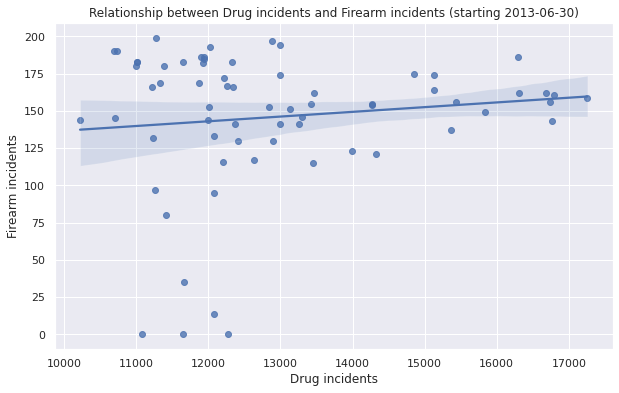

In [134]:
#Plotting drug vs firearm crimes
plt.figure(figsize=(10, 6))
sns.regplot(data = drugs_and_firearm_pd_modified, x="Drug incidents", y="Firearm incidents")
plt.title("Relationship between Drug incidents and Firearm incidents (starting 2013-06-30)")
plt.grid(True)
plt.show()

In [135]:
drugs_and_firearm_pd_modified['Year'] = \
drugs_and_firearm_pd_modified['Year'].astype('category') # convert the new column to a categorical variable

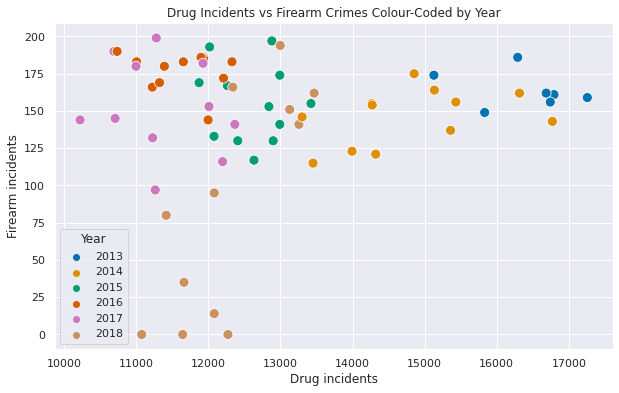

In [136]:
#Plotting a color coded scattered plot of drug crimes and years showing the relationship by year
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Drug incidents', 
    y='Firearm incidents', 
    data=drugs_and_firearm_pd_modified, 
    hue='Year', 
    palette='colorblind', 
    s=100
).set(
    title='Drug Incidents vs Firearm Crimes Colour-Coded by Year'
)
plt.show()

### Spatial analyisys acrosss cities, to look at the question: "Across different cities where both crimes happen, are higher numbers of drug crimes associated with higher numbers of firearm crimes?"

In [137]:
firearm_grouped_df = firearm_incidents_with_cityname.groupBy('city_name').agg(F.count('Crime type').alias('Firearm crimes'))

# Sort the DataFrame for better readability
firearm_sorted_df = firearm_grouped_df.sort('city_name')
# Show the result
firearm_sorted_df.show()

+--------------------+--------------+
|           city_name|Firearm crimes|
+--------------------+--------------+
|                Adur|             2|
|           Allerdale|            20|
|        Amber Valley|            27|
|                Arun|            14|
|            Ashfield|            21|
|             Ashford|            15|
|      Aylesbury Vale|            26|
|             Babergh|             3|
|Barking and Dagenham|            46|
|              Barnet|            43|
|            Barnsley|            63|
|   Barrow-in-Furness|            19|
|            Basildon|            35|
|Basingstoke and D...|            14|
|           Bassetlaw|            24|
|Bath and North Ea...|             6|
|             Bedford|            49|
|              Bexley|            15|
|          Birmingham|           227|
|               Blaby|             1|
+--------------------+--------------+
only showing top 20 rows



In [138]:
# Filter for drug incidents
drug_crimes_df = crime_data_df.filter(
    (crime_data_df["Crime type"] == "Drugs"))

drug_crimes_df.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|Crime type|Last outcome category|Context|Year|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|   -2.507|51.408557|On or near Tenby ...|E01014404|Bath and North Ea...|     Drugs|                 null|   null|2011|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.492186|51.413386|On or near Dragon...|E01014396|Bath and North Ea...|     Drugs|                 null|   null|2011|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.483019|51.412705|On or near Bath Road|E010

In [139]:
# Renaming the LSOA name column
drug_crimes_df = drug_crimes_df.withColumnRenamed('LSOA name', "LSOA_name")
drug_crimes_df.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA_name|Crime type|Last outcome category|Context|Year|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|   -2.507|51.408557|On or near Tenby ...|E01014404|Bath and North Ea...|     Drugs|                 null|   null|2011|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.492186|51.413386|On or near Dragon...|E01014396|Bath and North Ea...|     Drugs|                 null|   null|2011|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.483019|51.412705|On or near Bath Road|E010

In [140]:
# Extract the city name from the geography column (by removing the last 5 
#characters since those are standard in all the cty names (4 characters plusa space))
drug_crimes_with_cityname = drug_crimes_df.withColumn("city_name", \
                                                                        F.expr("substring(LSOA_name, 1, length(LSOA_name)-5)"))
drug_crimes_with_cityname.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+--------------------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA_name|Crime type|Last outcome category|Context|Year|           city_name|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+----+--------------------+
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|   -2.507|51.408557|On or near Tenby ...|E01014404|Bath and North Ea...|     Drugs|                 null|   null|2011|Bath and North Ea...|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.492186|51.413386|On or near Dragon...|E01014396|Bath and North Ea...|     Drugs|                 null|   null|2011|Bath and North Ea...|


In [141]:
drugs_grouped_df = drug_crimes_with_cityname.groupBy('city_name').agg(F.count('Crime type').alias('Drug crimes'))

# Sort the DataFrame for better readability
drugs_sorted_df = drugs_grouped_df.sort('city_name')
# Show the result
drugs_sorted_df.show()

+--------------------+-----------+
|           city_name|Drug crimes|
+--------------------+-----------+
|                null|      69442|
|                Adur|        973|
|           Allerdale|       1942|
|        Amber Valley|       1835|
|                Arun|       2517|
|            Ashfield|       1779|
|             Ashford|       1238|
|      Aylesbury Vale|       2456|
|             Babergh|       1021|
|Barking and Dagenham|       6348|
|              Barnet|       5979|
|            Barnsley|       4995|
|   Barrow-in-Furness|       1390|
|            Basildon|       3690|
|Basingstoke and D...|       3510|
|           Bassetlaw|       1327|
|Bath and North Ea...|       2062|
|             Bedford|       2741|
|              Bexley|       4633|
|          Birmingham|      21676|
+--------------------+-----------+
only showing top 20 rows



In [142]:
drugs_plus_firearms_df = firearm_sorted_df.join(drugs_sorted_df, 'city_name')
drugs_plus_firearms_df.show(5)

+--------------+--------------+-----------+
|     city_name|Firearm crimes|Drug crimes|
+--------------+--------------+-----------+
|     Worcester|            36|       2614|
|     Charnwood|            10|       1606|
|North Kesteven|             4|        683|
|          Arun|            14|       2517|
| Epping Forest|             9|       1639|
+--------------+--------------+-----------+
only showing top 5 rows



In [143]:
#Converting to Pandas
drugs_plus_firearms_pd = drugs_plus_firearms_df.toPandas()
#Removing the duplicate 'month' column
drugs_plus_firearms_pd.head(10)

,city_name,Firearm crimes,Drug crimes
0,Worcester,36,2614
1,Charnwood,10,1606
2,North Kesteven,4,683
3,Arun,14,2517
4,Epping Forest,9,1639
5,Waveney,13,1997
6,Stroud,4,1251
7,Maldon,3,468
8,New Forest,5,1727
9,Sedgemoor,12,1674


In [144]:
#Pearson's correlation 
correlation = drugs_plus_firearms_pd["Firearm crimes"].corr(drugs_plus_firearms_pd["Drug crimes"])
print("The Pearson correlation coefficient citywise is:", correlation)

The Pearson correlation coefficient citywise is: 0.8486781405631976


In [145]:
#R^2
print("The coefficient of determination is:", correlation*correlation)

The coefficient of determination is: 0.7202545862698065


In [146]:
# Spearman's correlation
correlation_spearman = \
drugs_plus_firearms_pd["Firearm crimes"].corr(drugs_plus_firearms_pd["Drug crimes"], method='spearman')
print("The Spearman correlation coefficient citywise is:", correlation_spearman)

The Spearman correlation coefficient citywise is: 0.8406276842974296


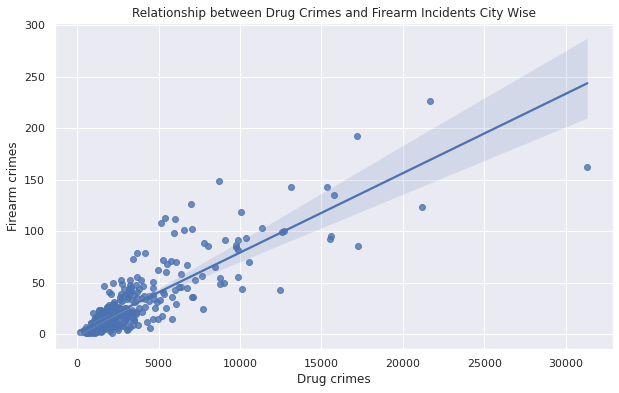

In [147]:
plt.figure(figsize=(10, 6))
sns.regplot(data = drugs_plus_firearms_pd, x="Drug crimes", y="Firearm crimes")
plt.title("Relationship between Drug Crimes and Firearm Incidents City Wise")
plt.grid(True)
plt.show()